# Foundations of Data Mining: Assignment 3
Students: Junzhou Jiang(0963164)  ,  Nan Yang(0963123)

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "none"

In [2]:
# This is a temporary read-only OpenML key.
oml.config.apikey = '6455db467b30b2fdf1d17d27e33fc28c'

##  Random Projections with 1-NN

### Implementation of Random Projections

In [4]:
import numpy as np
def generateRandomMatrix(n_components,n_features):
    components = np.random.binomial(1, 0.5, (n_components, n_features)) * (2/np.sqrt(n_features)) - 1/np.sqrt(n_features)
    return components
def randomProjection(n_components,X):
    n_features = X.shape[1]
    rp =np.dot(X,generateRandomMatrix(n_components,n_features).T)
    return rp

###  Study the effect on pairwise distances

In [3]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
# Get the predictors X and the labels y
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); 

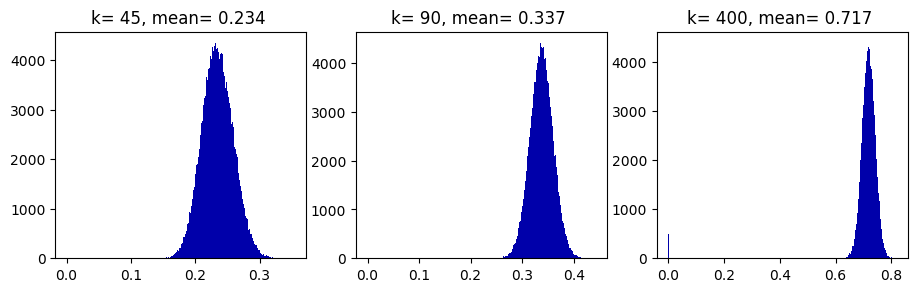

In [144]:
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from numpy import inf
from numpy import nan

fig, axes = plt.subplots(1, 3, figsize=(11,3))
ks = [45,90,400]
for k,ax in zip(ks,axes):   
    rp = randomProjection(k,X)
    d1 = euclidean_distances(rp[:500],rp[:500])
    d2 = euclidean_distances(X[:500],X[:500])
    pd = d1/d2
    a =  pd.flatten()
    a[a == inf] = 0
    a = np.nan_to_num(a)
    ax.hist(a, bins='auto')  # plt.hist passes it's arguments to np.histogram
    ax.set_title("k= %d, mean= %.3f "% (k,np.array(a).mean()))

From the figures above we observe that the values are concentrated around a fixed value for different values of k. We found an increase of the fixed value as the increase of k, the mean value is around 0.22 for k =45, 0.33 for k = 90, 0.72 for k=400. With a simple calulation, we found a formula that the $ mean = \sqrt{\frac{k}{d}}$.  Here we test our inference with k = 600. According to our formula for the mean value, the mean for k=600 should be around 0.875. 


In [147]:
rp = randomProjection(600,X)
d1 = euclidean_distances(rp[:500],rp[:500])
d2 = euclidean_distances(X[:500],X[:500])
pd = d1/d2
a =  pd.flatten()
a[a == inf] = 0
a = np.nan_to_num(a)
print("The mean value for K=600 is %.3f"%np.array(a).mean())

The mean value for K=600 is 0.874


The above test just increase our confidence in our inference. So when the number of components increases, the ratio of Euclidean distance is increased, which means the Euclidean distance between projected data points are more closed to the Euclidean distance between original data points. Noteworthy, the ratio will increase at a slower rate as the increase of K, which might means we can use a relative low value of k in our model for promoting efficiency while still have a good performance. Next step, we study the effect of random projection on clasffication to verify our idea.

### Study the effect on classification

In [6]:
# split the dataset, subsetPercent is used to control the percentage of samples
X_train,y_train = X[:60000],y[:60000]
X_test,y_test = X[60000:],y[60000:]

First we use 1-nn classifier without random projection to train data and evaluate its perfomance by predicting on both train set and test set.

In [118]:
from sklearn import neighbors
# Build up a Knn classifier with its default settings
knn_norp = neighbors.KNeighborsClassifier(n_neighbors=1)
# fit train data set
knn_norp.fit(X_train, y_train)
# score
score_norp = knn_norp.score(X_test, y_test)
print("The 1-nn predictive accuracy with default setting on test set is: %f "% score_norp )
pred_norp = knn_norp.predict(X_test)

The 1-nn predictive accuracy with default setting on test set is: 0.969100 


In [119]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print("1. Confusion matrix:\n{}".format(confusion_matrix(y_test, pred_norp)))
print("")
print("2. classification report:\n{}".format(classification_report(y_test, pred_norp)))
print("3. Weighted average f1 score: {:.3f}".format(f1_score(y_test, pred_norp, average="weighted")))

1. Confusion matrix:
[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1129    3    0    1    1    1    0    0    0]
 [   7    6  992    5    1    0    2   16    3    0]
 [   0    1    2  970    1   19    0    7    7    3]
 [   0    7    0    0  944    0    3    5    1   22]
 [   1    1    0   12    2  860    5    1    6    4]
 [   4    2    0    0    3    5  944    0    0    0]
 [   0   14    6    2    4    0    0  992    0   10]
 [   6    1    3   14    5   13    3    4  920    5]
 [   2    5    1    6   10    5    1   11    1  967]]

2. classification report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       980
          1       0.97      0.99      0.98      1135
          2       0.98      0.96      0.97      1032
          3       0.96      0.96      0.96      1010
          4       0.97      0.96      0.97       982
          5       0.95      0.96      0.96       892
          6       0.98      0.99      0.98       

We can observe that the prediction on test set are good with only few misclassifications. Both precision and recall are quite high, contributing to weighted average f1 score 0.969. Then we use 1-nn with random projection to do the training and testing.

In [11]:
knn_accuracy_test = []
pred =[]
ks = [45,90,400]

for k in ks:   
    rp = randomProjection(k,X)
    # split up data
    X_train,y_train = rp[:60000],y[:60000]
    X_test,y_test = rp[60000:],y[60000:]
       
    # Build up a Knn classifier with its default settings
    knn = neighbors.KNeighborsClassifier(n_neighbors=1)
    # fit train data set
    knn.fit(X_train, y_train)
    # score
    knn_accuracy_test.append(knn.score(X_test, y_test))
    # pred
    pred.append(knn.predict(X_test))

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

for i in range(len(ks)):
    print("K = %d"%ks[i])
    print("1. Confusion matrix:\n{}".format(confusion_matrix(y_test, pred[i])))
    print("")
    print("2. Classification report:\n{}".format(classification_report(y_test, pred[i])))
    print("3. Weighted average f1 score: {:.3f}".format(f1_score(y_test, pred[i], average="weighted")))
    print("-----------------------------------------------------------")

K = 45
1. Confusion matrix:
[[ 965    0    2    1    0    4    4    0    3    1]
 [   0 1129    2    1    0    0    1    1    0    1]
 [  12    7  940   19    4    5    6   22   11    6]
 [   3    1    9  940    3   23    0    8   15    8]
 [   0    6    1    4  901    1    7    7    1   54]
 [   5    3    3   29    5  815    8    4   10   10]
 [   7    3    3    0    7    4  929    2    1    2]
 [   0   20    8    1    7    2    1  957    2   30]
 [   9    8   15   25    6   30    8   10  854    9]
 [   3    4    3   11   19    5    1   27    5  931]]

2. Classification report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       980
          1       0.96      0.99      0.97      1135
          2       0.95      0.91      0.93      1032
          3       0.91      0.93      0.92      1010
          4       0.95      0.92      0.93       982
          5       0.92      0.91      0.92       892
          6       0.96      0.97      0.97

We can observe that prediction results are getting better when the number of components increases, as well as precision and recall. When the number of components is 400, the result of prediction on test set(0.966) pretty approaches to the result obtained with full features(0.969). 
However, the required prediction time is much less than original model required. Hence, the prediction efficiency can be promoted by using random projection before trainning model but still maintains a high accuracy, which coincides with our intuition from the previous question.


## PCA of a handwritten digits
Analyze the first two principal components of the class with label $4$ of the MNIST data set (those are images that each depict a handwritten "4"). Perfom the steps (a), (b), (c) described below. Note that these steps are similar to the analysis given in the lecture. Include all images and plots in your report. You may use sklearn.decomposition.PCA for this assignment. Do not scale the data.

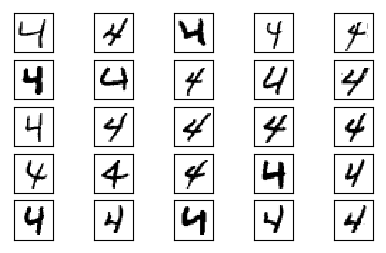

In [5]:
# build a list of figures on a 5x5 grid for plotting
def buildFigure5x5(fig, subfiglist):
    
    for i in range(0,25):
        pixels = np.array(subfiglist[i], dtype='float')
        pixels = pixels.reshape((28, 28))
        a=fig.add_subplot(5,5,i+1)
        imgplot =plt.imshow(pixels, cmap='gray_r')
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    return

# find the first 25 instances with label '4' and plot them
imgs = np.empty([25, 28*28], dtype='float')
j=0
for i in range(0,len(X)):
    if(y[i] == 4) and j < 25:
        imgs[j] = np.array(X[i], dtype='float')
        j += 1

buildFigure5x5(plt.figure(1),imgs)
plt.show()

In [6]:
mnist_data = oml.datasets.get_dataset(554) # Download MNIST data
# Get the predictors X and the labels y
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute); 

### Step (a)
 Generate a scatter plot of the data in the space spanned by the first two principal components of PCA. Reconstruct $25$ points on a $5 \times 5$ grid in this space that cover the variation of the data. Render each point as an image. Arrange the images in a $5 \times 5$ grid.

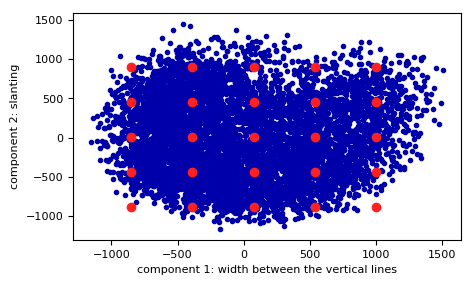

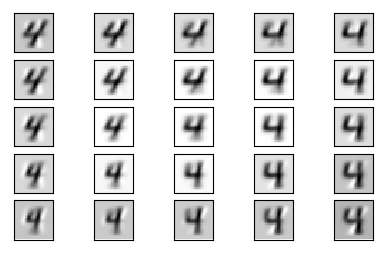

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2,svd_solver='full')
pcaf = pca.fit_transform(X[y == 4])
plt.scatter(*pcaf.T, marker='.')

grid1 = np.arange(-850, 1001, 462.5)
grid2 = np.arange(901, -880,-445)
grid = np.array(list([i,j] for j in grid2 for i in grid1))
plt.scatter(*grid.T);

plt.ylabel("component 2: slanting")
plt.xlabel("component 1: width between the vertical lines")

label = []
for i in grid:
    label.append(pca.mean_ + i[0] * pca.components_[0] + i[1] * pca.components_[1]) 
buildFigure5x5(plt.figure(2), label)

plt.show();

### Step (b) 
For each of the reconstructed points, find the original instance that is closest to it in the projection on the first two components (measured using Euclidean distance). Render the instances arranged in a $5 \times 5$ grid such that their position matches the rendering in (a).

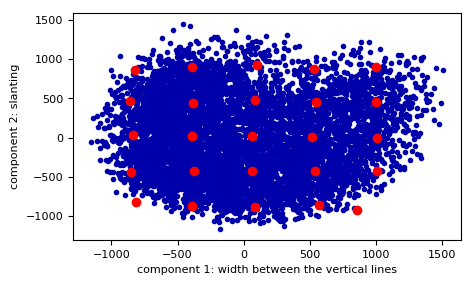

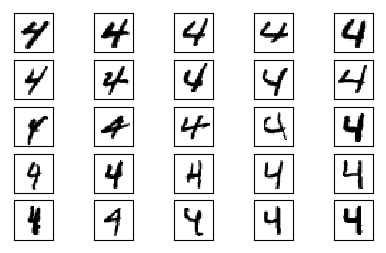

In [8]:
closest_label = []
closest_point = []
label4 = X[y == 4]
for i in grid:
    distance = ((pcaf - i)**2).sum(axis=1)
    closest_label.append(label4[np.argmin(distance)])
    closest_point.append(pcaf[np.argmin(distance)])


plt.scatter(*pcaf.T, marker='.')
plt.ylabel("component 2: slanting")
plt.xlabel("component 1: width between the vertical lines")

for j in closest_point:
    plt.scatter(j[0], j[1], color = 'red')

buildFigure5x5(plt.figure(2), closest_label)


### Step (c)
Render the mean and the first two principal components as images. What is your interpretation of the first two components, i.e., which aspect of the data do they capture? Justify your interpretation, also using your results of Steps (a) and (b).


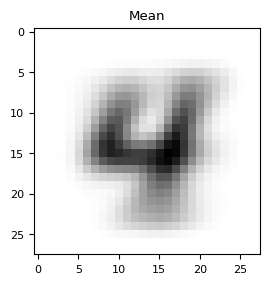

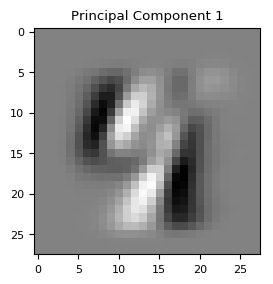

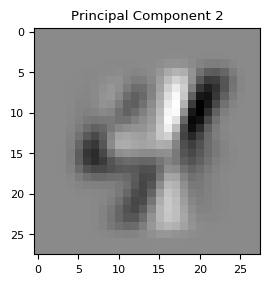

In [9]:
plt.figure()
plt.title('Mean')
pixels = np.array(X[y == 4].mean(axis=0), dtype='float')
pixels = pixels.reshape((28, 28))
plt.imshow(pixels, cmap='gray_r')
plt.figure()
#pca = PCA(n_components=2).fit(X[y == 4])
plt.title('Principal Component 1')
pixels = np.array(pca.components_[0], dtype='float')
pixels = pixels.reshape((28, 28))
plt.imshow(pixels, cmap='gray_r')
plt.figure()
plt.title('Principal Component 2')
pixels = np.array(pca.components_[1], dtype='float')
pixels = pixels.reshape((28, 28))
plt.imshow(pixels, cmap='gray_r')

plt.show();

From the step(a) and step(b) we can observe that the length between two vertical lines of 4 is getting longer from left to right which is casued by component 1. And it can also be clearly seen that the digit 4 is getting more slant from bottom to up, so we think the component 2 interprets the slanting of the digit. From the figures above, we can confirm our inference, the componnet 1 image has longer distance between two vertical lines of 4 compared to "mean" image. And the component 2 image shows more slant digit 4 than "mean" image.

## Projection onto a hyperplane (4 points)
Let $F$ be a $k$-dimensional hyperplane given by the parametric representation
$$ g(\lambda) = \mu + {\bf V} \lambda,$$
where $\mu \in \mathbb{R}^d$ and the columns of $\bf V$ are pairwise orthogonal and unit vectors $\bf v_1,\dots,\bf v_k \in \mathbb{R}^d$.
Let $f:\mathbb{R}^d\rightarrow F$ be the projection that maps every point ${\bf p} \in \mathbb{R}^d$ to its nearest point on $F$ (where distances are measured using the Euclidean distance). We can write the projection into the subspace spanned by $\bf v_1,\dots,\bf v_k$ as follows 
$$f({\bf p}) = {\bf V}^T ({\bf p}-\mu).$$

Prove that for any ${\bf p,\bf q} \in \mathbb{R}^d$, it holds that
$$ \|f({\bf p})-f({\bf q})\| \leq \|{\bf p-\bf q}\|. $$

(Hint: Assume first that $\mu=0$. Rewrite $f$ using a rotation followed by an orthogonal projection. What happens to the distance in each step? Generalize to arbitrary $\mu$.)


### Answer
The question requires us to prove the distance between two points projected on hyperplane is always equivalent or smaller than the distance between these two points on original plane. 

To prove this , we first assume $\mu = 0$. Then we have $$f({\bf p}) = {\bf V}^T {\bf p}.$$
We know that $V$ consists of the k basic vectors of the hyperplane. The projection can be expressed by a rotation matrix followed by an orthogonal projection. So we can have $$f({\bf p}) = {\bf PM} {\bf p}.$$ where $\bf P$ is orthogonal projection onto first $k$ coordinates, $\bf M$ is the rotation to align each $v_{i}$.

Since $f$ is a linear transformation, we can have following:
$$ \|f({\bf p})-f({\bf q})\| = \|f({\bf p-q})\| = \|\bf PM(p-q)\|  $$ 
and as we know the rotation would not change the distance between points, so the formula can be further transformed into: 
$$ \|\bf PM(p-q)\| = \|\bf P(p-q)\| =  \|\bf Pa\| $$ 
where $\bf a = (p-q)$.

because $\bf P$ is a $kxd$ orthogonal projection matrix, it selects $k$ elements from $d$ elemnts of the original vector $a$, so the length of the resulting vector $\bf Pa$ must be smaller than or equal to that of the original vector since $k\leq{d}$, which is
$$\|\bf Pa\|\leq{\|a\|}$$
Then we can conclude that for $\mu = 0$, 
$$ \|f({\bf p})-f({\bf q})\| \leq \|{\bf p-\bf q}\|$$
When $\mu \neq{0}$, we have $f({\bf p}) = {\bf V}^T {\bf (p-\mu)}$. By doing similar transformation, we can have $f({\bf p}) = {\bf PM} {\bf (p-\mu)}$

According to multiplication law of marix, we get 
$\|f({\bf p}) - f({\bf p})\| = \|{\bf PM} {\bf (p-\mu)} - {\bf PM} {\bf (q-\mu)}\| = \|{\bf PM} {\bf (p-\mu- q+\mu)}\| = \|{\bf PM} {\bf (p- q)}\|$

Then we can have similar proof as $\mu = 0$.
Finally, we can conclude that $ \|f({\bf p})-f({\bf q})\| \leq \|{\bf p-\bf q}\|$ for all $\mu$.

## Locality-sensitive hashing

$H$ is a family of $(d_1,d_2,p_1,p_2)$-locality-sensitive hash functions if it holds that
\begin{align}
\text{if}\quad d({\bf p,q})\leq d_1 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \geq p_1 \quad \\
\text{if}\quad d({\bf p,q})\geq d_2 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \leq p_2 \quad
\end{align}

### Case: $p_2=0$
Assume that $p_2=0$ and assume we have a total numer of $m$ hash
functions from this family available.  Which combination of AND-constructions
and OR-constructions should we use to amplify the hash family?

### Answer: 
As we know, the ideal value of $p_1$ and $p_2$ are 1 and 0 respectively. Here we already had $p_2 = 0$, so we should focus on amplifying $p_1$ to 1 which means increasing the collision.

First let us look at the definition of AND-construction and OR-construction.
Refer to page 22 of slide 10-ish.PDF we can have definitions as below:

#### AND :
$H \rightarrow H'$ Pick $r$ functions $h_1$; $h_2$;... $h_r$ without replacement from H.
Define $h'$ by $h'(x) = h'(y) \Leftrightarrow h_i(x) = h_i(y)$ for $\forall 1\leq{i}\leq{r}$. where functions $H'$ is the family of such $h'$. The AND-construction decreases the probability of collision in $h'$ to $p' = p^{r}$.

Now we plot out the collision probability of AND-construction.

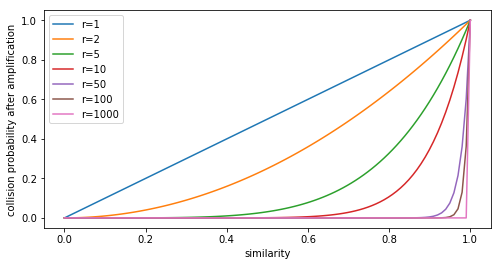

In [25]:
import matplotlib.pyplot as plt
import numpy as np
X = np.linspace(0, 1, num=100)
r = [1,2,5,10,50,100,1000]
plt.figure(figsize = (8,4))
for i in r:
    plt.plot(X,X**i,label = 'r=%d'%i)
    
plt.xlabel('similarity')
plt.ylabel('collision probability after amplification')    
plt.legend()
plt.show()

From the above we can observe that all the other lines are below the line $r=1$, so AND-construction reduce the collision. As the increase of $r$, the probability decreases. But we should also look at how it works on the relationship between $p_1$ and $p_2$.

$\frac{p_1'}{p_2'} = \frac{p_1^{r}}{p_2^{r}}$ Since we require $p_1 > p_2$, we can obtain that $\frac{p_1'}{p_2'} \gg{\frac{p_1}{p_2} }$

which indicates that AND-construction actually amplifiers the difference in collision probability between nearby and far points. 

#### OR: 
$H \rightarrow \hat{H}$ Pick $b$ functions $h_1$; $h_2$;... $h_b$ without replacement from H.
Define $\hat{h}$ by $\hat{h}(x) = \hat{h}(y) \Leftrightarrow h_i(x) = h_i(y)$ for at least one $i$. where functions $\hat{H}$ is the family of such $\hat{h}$. The OR-construction make the probability of collision in $\hat{h}$ to $\hat{p} = 1-(1-p)^{b}$.

Now we plot out the collision probability of OR-construction.

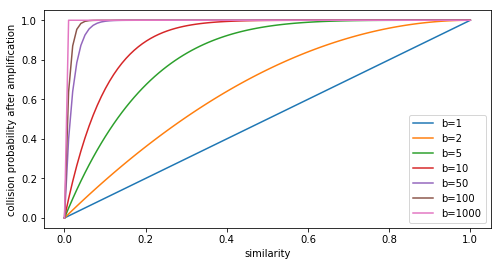

In [26]:
import matplotlib.pyplot as plt
import numpy as np
X = np.linspace(0, 1, num=100)
b = [1,2,5,10,50,100,1000]
plt.figure(figsize = (8,4))
for i in b:
    plt.plot(X,(1-(1-X)**i),label = 'b=%d'%i)

plt.xlabel('similarity')
plt.ylabel('collision probability after amplification') 
plt.legend()
plt.show()

From the graph above we can see that all the other lines are above the line $b=1$, so OR-construction boosts the probability of a collision. Now we look at how it works for the relationship between $p_1$ and $p_2$.
We have:

$\frac{1-\hat{p_1}}{1-\hat{p_2}} = \frac{(1-p_1)^{b}}{(1-p_2)^{b}} \ll{\frac{1-p_1}{1-p_2}}$ 

From the formula above we can know that OR-construction boosts collision probability more for neaby points than far points.

#### AND-OR:

Refer to page 19 and 20 of slide 10-ish.PDF.

From the slide we know that the combination of AND-construction and OR-construction lead collision probability to $\tilde{p} = 1-(1-p^{r})^{b}$. We can understand it as there are totally $b$ bands with $r$ functions in each band. 
Now we plot out the collision probability of AND-OR combination.

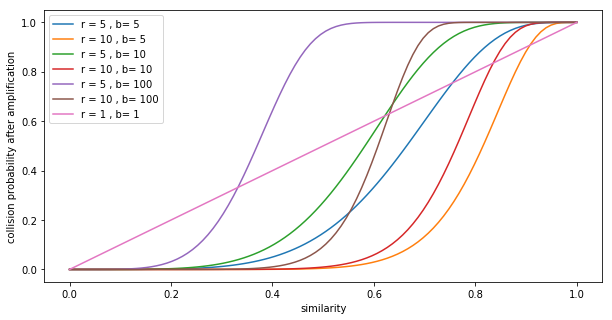

In [27]:
X = np.linspace(0, 1, num=100)
b = [5,10,100]
r = [5,10]
plt.figure(figsize = (10,5))
for i in b:
    for j in r:
        plt.plot(X,(1-(1-X**j)**i),label = 'r = %d , b= %d'%(j,i))

plt.plot(X,(1-(1-X**1)**1),label = 'r = %d , b= %d'%(1,1))
plt.xlabel('similarity')
plt.ylabel('collision probability after amplification')
plt.legend()
plt.show()

From the graph above, we can observe that all the other lines have intersection with the line $r=1,b=1$ which is the line for collision probability before amplication. So for some value of $p$, a amplication will reduce the collision probability while for some the effects are opposite. Therefore, by choosing a proper combination of $r$ and $b$, we can achieve our ideal collision probability for $p_1 =1 $ and $p_2 = 0$.

After understanding the definitions, we can go back to our question. The case is $p_2 = 0$ which only requires us to push the value of $p_1$ to 1. So we think the best solution would be only using OR-construction to effectively promote the value of $p_1$ while still mantains $p_2=0$, which requires $r=1,b=m$.




### Case: $p_2=\frac{1}{n}$
Now assume that $p_2=\frac{1}{n}$ and assume we have $n$ data points $\bf P$
which are stored in a hash table using a randomly chosen function $h$ from $H$.
Given a query point $\bf q$, we retrieve the points in the hash bucket with index $h(\bf q)$ to search 
for a point which has small distance to $\bf q$. 
Let $X$ be a random variable that is equal to the size of the set 

\begin{align}
\left\{{\bf p \in P}\,:\, h({\bf p})=h({\bf q}) \,\wedge\, d({\bf p,q}) \geq d_2\right\}\
\end{align}

which consists of the false positives of this query.

Derive an upper bound on the expected number of false-positives $\mathbb{E}\left[ X \right]$ using $p_2$. Explain each step of your derivation.

### Answer: 
From the description above, we can basically understand that false-postives means two data points collide in a same hash functions but they are actually quite far away from each other with the distance larger than $d_{2}$.

To answer this question, first of all, we defined our worst case as below.

All the other $n-1$ data points are far away from $q$ with distance larger than $d_{2}$, but they were all hashed into the same hash bucket $h(q)$.

By combining what we have learnt before, we know that each point has independent probability of less than $p_{2}$ to be hashed into $h(q)$ bucket falsely. Therefore, the probability of hashing $k$ data points falsely into $h(q)$ is less than $(\frac{1}{n})^{k}$. 
Therefore, the upper bound on the expected number of false-positives should be:

$$ \mathbb{E}\left[ X \right] \leq{ \sum_{k=0}^{n-1}k(\frac{1}{n})^{k}} < {\sum_{k=0}^{n-1}n(\frac{1}{n})^{k}} = \sum_{k=0}^{n-1}(\frac{1}{n})^{k-1} = \frac{1-(\frac{1}{n})^{n-1}}{1-\frac{1}{n}}<\frac{1}{1-\frac{1}{n}} = \frac{n}{n-1}$$